## Library import


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import math
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.special import softmax
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import emoji
import re
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    cohen_kappa_score,
)
from scipy.stats import chi2_contingency

## Data Reading


In [ ]:
df = pd.read_csv("./Data/Health_and_Personal_Care_sampled.csv", index_col=False)
df_main = pd.read_csv("./Data/Health_and_Personal_Care.csv", index_col=False)

In [3]:
df = df.drop(
    [
        "images",
        "asin",
        "parent_asin",
        "user_id",
        "timestamp",
        "helpful_vote",
        "verified_purchase",
    ],
    axis=1,
)

df_main = df_main.drop(
    [
        "images",
        "asin",
        "parent_asin",
        "user_id",
        "timestamp",
        "helpful_vote",
        "verified_purchase",
    ],
    axis=1,
)

In [4]:
df.head(5)

,Id,rating,title,text,Id.1
0,216860,5.0,Wonderful,Amazing product. Works wonders at the homes I ...,216860
1,353419,5.0,Best crackers ever!,Those crackers remind me of the bread my mom u...,353419
2,432826,5.0,All organic ingredients,All organic for a competitive price. Good prod...,432826
3,285318,5.0,Great quality and price,They fit my 4y/o’s frames securely. The adjust...,285318
4,426580,4.0,"The product is great. The shipping, not so muc...","The product is great. The shipping, not so muc...",426580


In [5]:
df_main.head(5)

,Id,rating,title,text,Id.1
0,1,4.0,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,1
1,2,5.0,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,2
2,3,5.0,Fantastic,I have been suffering a couple months with hee...,3
3,4,4.0,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",4
4,5,1.0,Not for me,Didn't do a thing for me. Not saying they don'...,5


## Data Overview


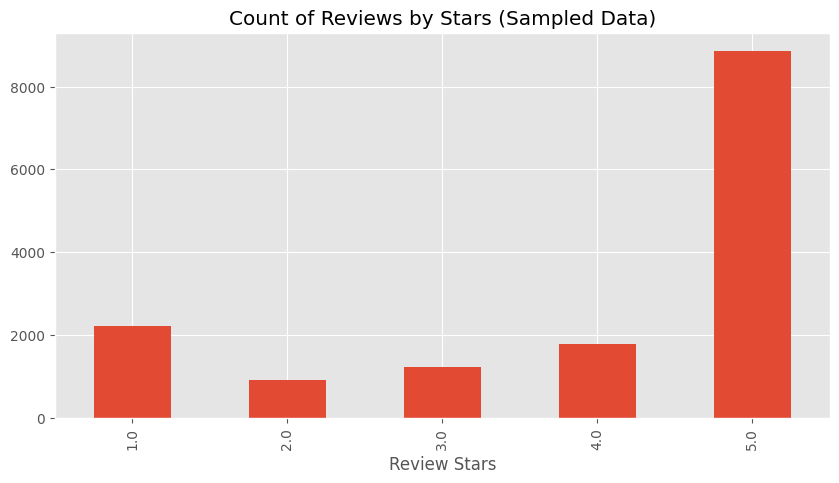

In [6]:
ax = (
    df["rating"]
    .value_counts()
    .sort_index()
    .plot(kind="bar", title="Count of Reviews by Stars (Sampled Data)", figsize=(10, 5))
)
ax.set_xlabel("Review Stars")
plt.show()

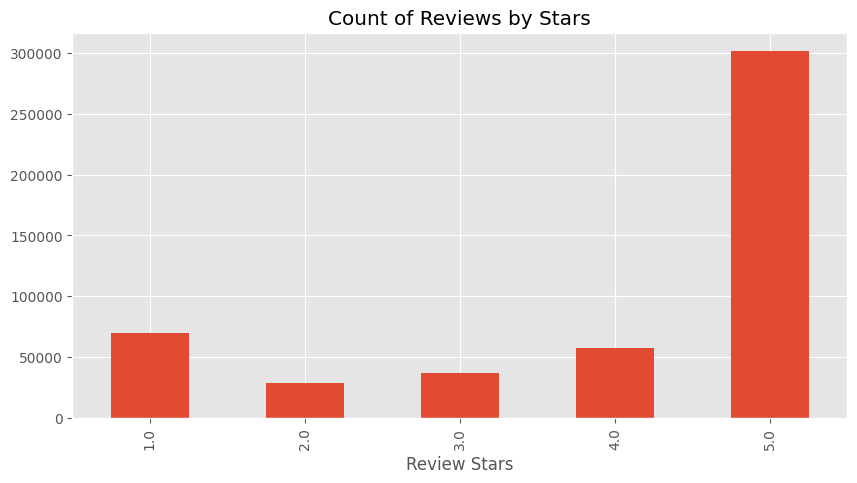

In [7]:
ax = (
    df_main["rating"]
    .value_counts()
    .sort_index()
    .plot(kind="bar", title="Count of Reviews by Stars", figsize=(10, 5))
)
ax.set_xlabel("Review Stars")
plt.show()

## Emoji Analysis


In [8]:
# Define a regex pattern for matching emojis.
emoji_pattern = re.compile(
    "["
    "\U0001f600-\U0001f64f"  # Emoticons
    "\U0001f300-\U0001f5ff"  # Symbols & pictographs
    "\U0001f680-\U0001f6ff"  # Transport & map symbols
    "\U0001f1e0-\U0001f1ff"  # Flags
    "]+",
    flags=re.UNICODE,
)


def contains_emoji(text):
    """Return True if the text contains at least one emoji."""
    # Ensure we only process strings.
    if not isinstance(text, str):
        return False
    return bool(emoji_pattern.search(text))

In [9]:
emoji_df = df_main[df_main["text"].apply(contains_emoji)]
emoji_df.to_csv("Data/Health_and_Personal_Care_emoji_reviews.csv", index=False)

In [10]:
df_emoji = pd.read_csv("Data/Health_and_Personal_Care_emoji_reviews.csv")

In [11]:
df_emoji.head()

,Id,rating,title,text,Id.1
0,98,5.0,top notch earplugs for swim/ shower!!,These are pool/shower quality ear plugs! I hav...,98
1,174,4.0,👍,👍,174
2,366,4.0,Pretty Patterns but the Edges Aren’t Perfectly...,I do love the color variations present through...,366
3,369,5.0,Sip Sip Hooray! 🍷🌿,The antioxidant-rich solution contained in the...,369
4,590,5.0,Thick & No Fuzz 😊,"These wipes are nice & thick, they smell good ...",590


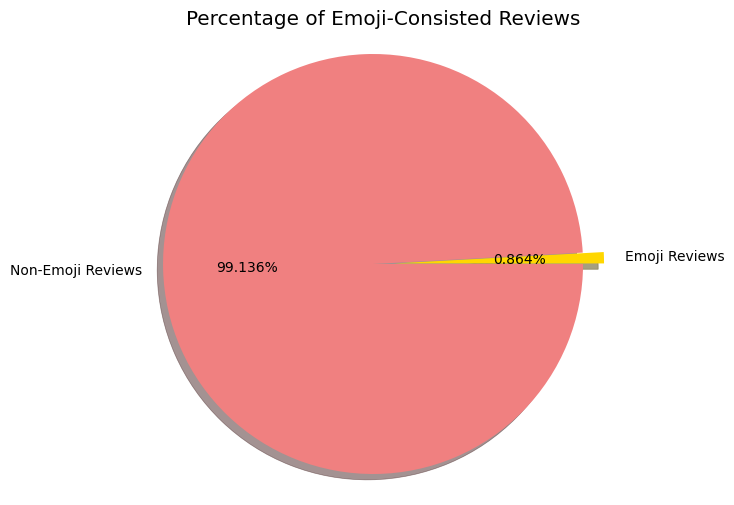

In [12]:
# Calculate counts for pie chart
total_reviews = df_main.shape[0]
emoji_reviews_count = df_emoji.shape[0]
non_emoji_reviews_count = total_reviews - emoji_reviews_count

# Define labels and sizes
labels = ["Emoji Reviews", "Non-Emoji Reviews"]
sizes = [emoji_reviews_count, non_emoji_reviews_count]
colors = ["gold", "lightcoral"]
explode = (0.1, 0)  # explode the emoji slice for emphasis

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct="%.3f%%",
    shadow=True,
    startangle=0,
)
plt.title("Percentage of Emoji-Consisted Reviews")
plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [13]:
emoji_pattern = re.compile(
    "["
    "\U0001f600-\U0001f64f"  # Emoticons
    "\U0001f300-\U0001f5ff"  # Symbols & pictographs
    "\U0001f680-\U0001f6ff"  # Transport & map symbols
    "\U0001f1e0-\U0001f1ff"  # Flags
    "]+",
    flags=re.UNICODE,
)


# Use a set to store unique emojis.
unique_emojis = set()

# Iterate over each text in the dataset
for text in df_emoji["text"]:
    if isinstance(text, str):
        emojis_found = emoji_pattern.findall(text)
        unique_emojis.update(emojis_found)

# Convert the set to a list if you need an array-like structure
unique_emojis_list = list(unique_emojis)
print(unique_emojis_list)

['😀👍', '👍👌', '🛌', '😊💗👍', '💝💝💝', '💝', '👓', '🙏🙏', '💤💤💤', '😧👎', '🐜', '😬', '🐍', '💲', '👍😇😇😇👼', '👍🙌🏻', '🇺🇲', '🏻👍🏻👍🏻😍😍😘😘', '👁', '🙂🙂🙂', '👉😎👉', '🎂', '😘👍🏻', '🙌🏼🙌🏼', '🙄😔😰', '😭😭😭😭', '🍀', '💯👍🏻', '😛', '😍😍😘', '🎀', '💫', '🍰🍓🐾', '😡', '😂😂', '🖒', '😂😅😂', '😂💗', '💪🏻💪🏻💪🏻', '👍🙂', '😆😆😆😆', '🍺🇦🇺', '💪💪💪', '😱😡', '👍🏾👍🏾👍🏾👍🏾👍🏾👍🏾', '👔', '👎👎', '😁👌🏼', '😩😂', '👍👍👍💪💪💪👊👊👊', '💜💜', '🙌🏻😆', '🎈🎈🎈🎈', '💪🏼👌🏼', '💧', '🔊', '👎🏻', '💪', '💜🌱💙🌱', '💡', '🙌🙌🙌', '💁', '📚', '😤😑😞', '😚', '🔋', '🙏🏿🙏🏿', '👍😊', '😭😭', '😳', '😡😡😡😡', '🛁', '😓😓😓', '💨', '👍👏👏', '👍💊', '😃👍', '👍🏽👍🏽👍🏽👍🏽', '💥', '😁', '👍🏻👍🏻👍🏻👍🏻👍🏻😀😀', '😑😞', '👎🏼👎🏼👎🏼', '🇺🇦', '👍🏽👍🏽🙌🏾🙌🏾👏🏽👏🏽', '🍓👍🏾', '😲', '👈🏼👈🏼', '🍀🍀', '😊👍👍', '😒😐', '👯', '🌟🌟🌟🌟🌟', '😄😁', '🌹', '👌🏼👍', '👎🏻😡', '😡😡', '😙😙😙', '😈', '😉🙂', '💨💨', '🙄😒', '👏🏼👏🏼👏🏼', '📦🙃😟', '👎🏾👎🏾', '🙂🙂😍😍', '🙄🙄🙄', '🔧', '🙏', '👍🏽👍🏽', '😂😂😂', '👏💗', '😣', '🏼😁', '😂👍🏼', '📃', '😭🙏💓', '💪🏻👏🏻💜💙', '👍💓', '👎👎👎👎👎👎', '😊👍🏻', '😂👍🍀', '👍🏾👍🏾', '💩💩💩💩💩💩💩💩💩💩', '😊😊💖', '💩💩💩', '🎃🚜', '😘😍', '👌🏾', '😄😃', '🏖', '🙏🏾', '😢😭', '🎉👍🏼🕺', '🙃🙂', '👍🏻💯', '😦', '🎯', '💪👍💪💯💞💕', '👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻', '💕👍💓', '🙌🏻', '👏🏼', '💋👍😇', '😌😌😅😅'

## Taking Sample and using VADER


In [14]:
example = df["text"][438]
print(example)

My feet love it 😋👌.


In [15]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['My', 'feet', 'love', 'it', '😋👌', '.']

In [16]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('My', 'PRP$'),
 ('feet', 'NNS'),
 ('love', 'VB'),
 ('it', 'PRP'),
 ('😋👌', 'NNP'),
 ('.', '.')]

In [17]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S My/PRP$ feet/NNS love/VB it/PRP 😋👌/NNP ./.)


In [18]:
sia = SentimentIntensityAnalyzer()

In [19]:
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [20]:
sia.polarity_scores("This is the worst thing ever.")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [21]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}

In [22]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text"]
    myid = row["Id"]
    # Check if text is missing or NaN
    if text is None or (isinstance(text, float) and math.isnan(text)):
        # Handle missing text (e.g., set neutral scores or skip)
        res[myid] = {"neg": 0.0, "neu": 0.5, "pos": 0.0, "compound": 0.0}
    else:
        res[myid] = sia.polarity_scores(str(text))

  0%|          | 0/15000 [00:00<?, ?it/s]

In [26]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how="left")

In [27]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,rating,title,text,Id.1
0,216860,0.000,0.480,0.520,0.7579,5.0,Wonderful,Amazing product. Works wonders at the homes I ...,216860
1,353419,0.000,1.000,0.000,0.0000,5.0,Best crackers ever!,Those crackers remind me of the bread my mom u...,353419
2,432826,0.000,0.635,0.365,0.5574,5.0,All organic ingredients,All organic for a competitive price. Good prod...,432826
3,285318,0.000,0.474,0.526,0.8779,5.0,Great quality and price,They fit my 4y/o’s frames securely. The adjust...,285318
4,426580,0.146,0.660,0.193,0.2500,4.0,"The product is great. The shipping, not so muc...","The product is great. The shipping, not so muc...",426580


## Analysing VADER Scores


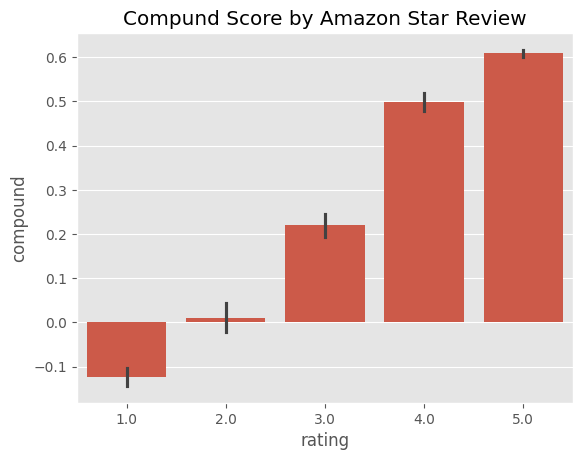

In [28]:
ax = sns.barplot(data=vaders, x="rating", y="compound")
ax.set_title("Compund Score by Amazon Star Review")
plt.show()

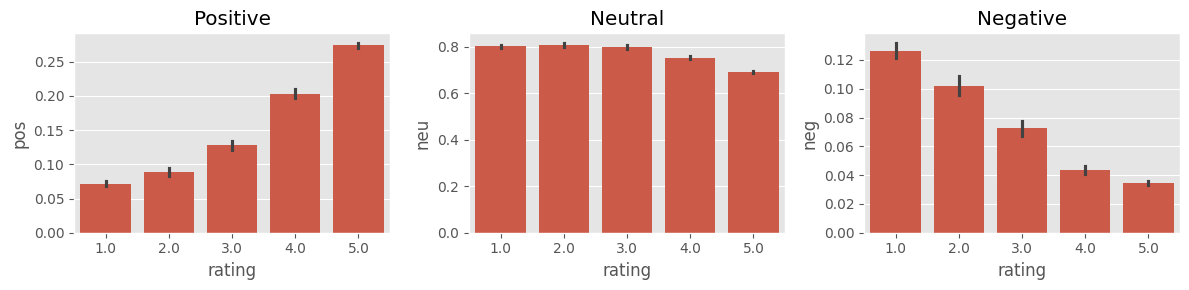

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x="rating", y="pos", ax=axs[0])
sns.barplot(data=vaders, x="rating", y="neu", ax=axs[1])
sns.barplot(data=vaders, x="rating", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

## Using RoBERTa Transormer Model


In [30]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [31]:
# VADER results on example
print(example)
sia.polarity_scores(example)

My feet love it 😋👌.


{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}

In [32]:
encoded_text = tokenizer(example, return_tensors="tf")
output = model(encoded_text)
# The output will be a tf.Tensor; convert to numpy array
scores = output.logits[0].numpy()
scores = softmax(scores)
scores_dict = {
    "roberta_neg": scores[0],
    "roberta_neu": scores[1],
    "roberta_pos": scores[2],
}
print(scores_dict)

{'roberta_neg': 0.0016816189, 'roberta_neu': 0.0210741, 'roberta_pos': 0.97724426}


In [33]:
def polarity_scores_roberta(example):
    # Truncate the input to the model's max length (e.g., 512 tokens)
    encoded_text = tokenizer(
        example, return_tensors="tf", truncation=True, max_length=512
    )
    output = model(encoded_text)
    scores = output.logits[0].numpy()
    scores = softmax(scores)
    result = {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2],
    }
    return result

In [34]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row["text"]
        myid = row["Id"]
        rating = row["rating"]

        if text is None or (isinstance(text, float) and math.isnan(text)):
            text = ""  # or choose to skip this row
        else:
            text = str(text)  # Convert non-string types to string

        vader_result = sia.polarity_scores(text)
        vader_result_rename = {
            f"vader_{key}": value for key, value in vader_result.items()
        }

        roberta_result = polarity_scores_roberta(text)

        both = {**vader_result_rename, **roberta_result, "rating": rating}
        res[myid] = both
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/15000 [00:00<?, ?it/s]

In [35]:
results_df = pd.DataFrame(res).T.reset_index().rename(columns={"index": "Id"})
results_df = results_df.merge(df, how="left")

## Showing Correlation between VADER and RoBERTa


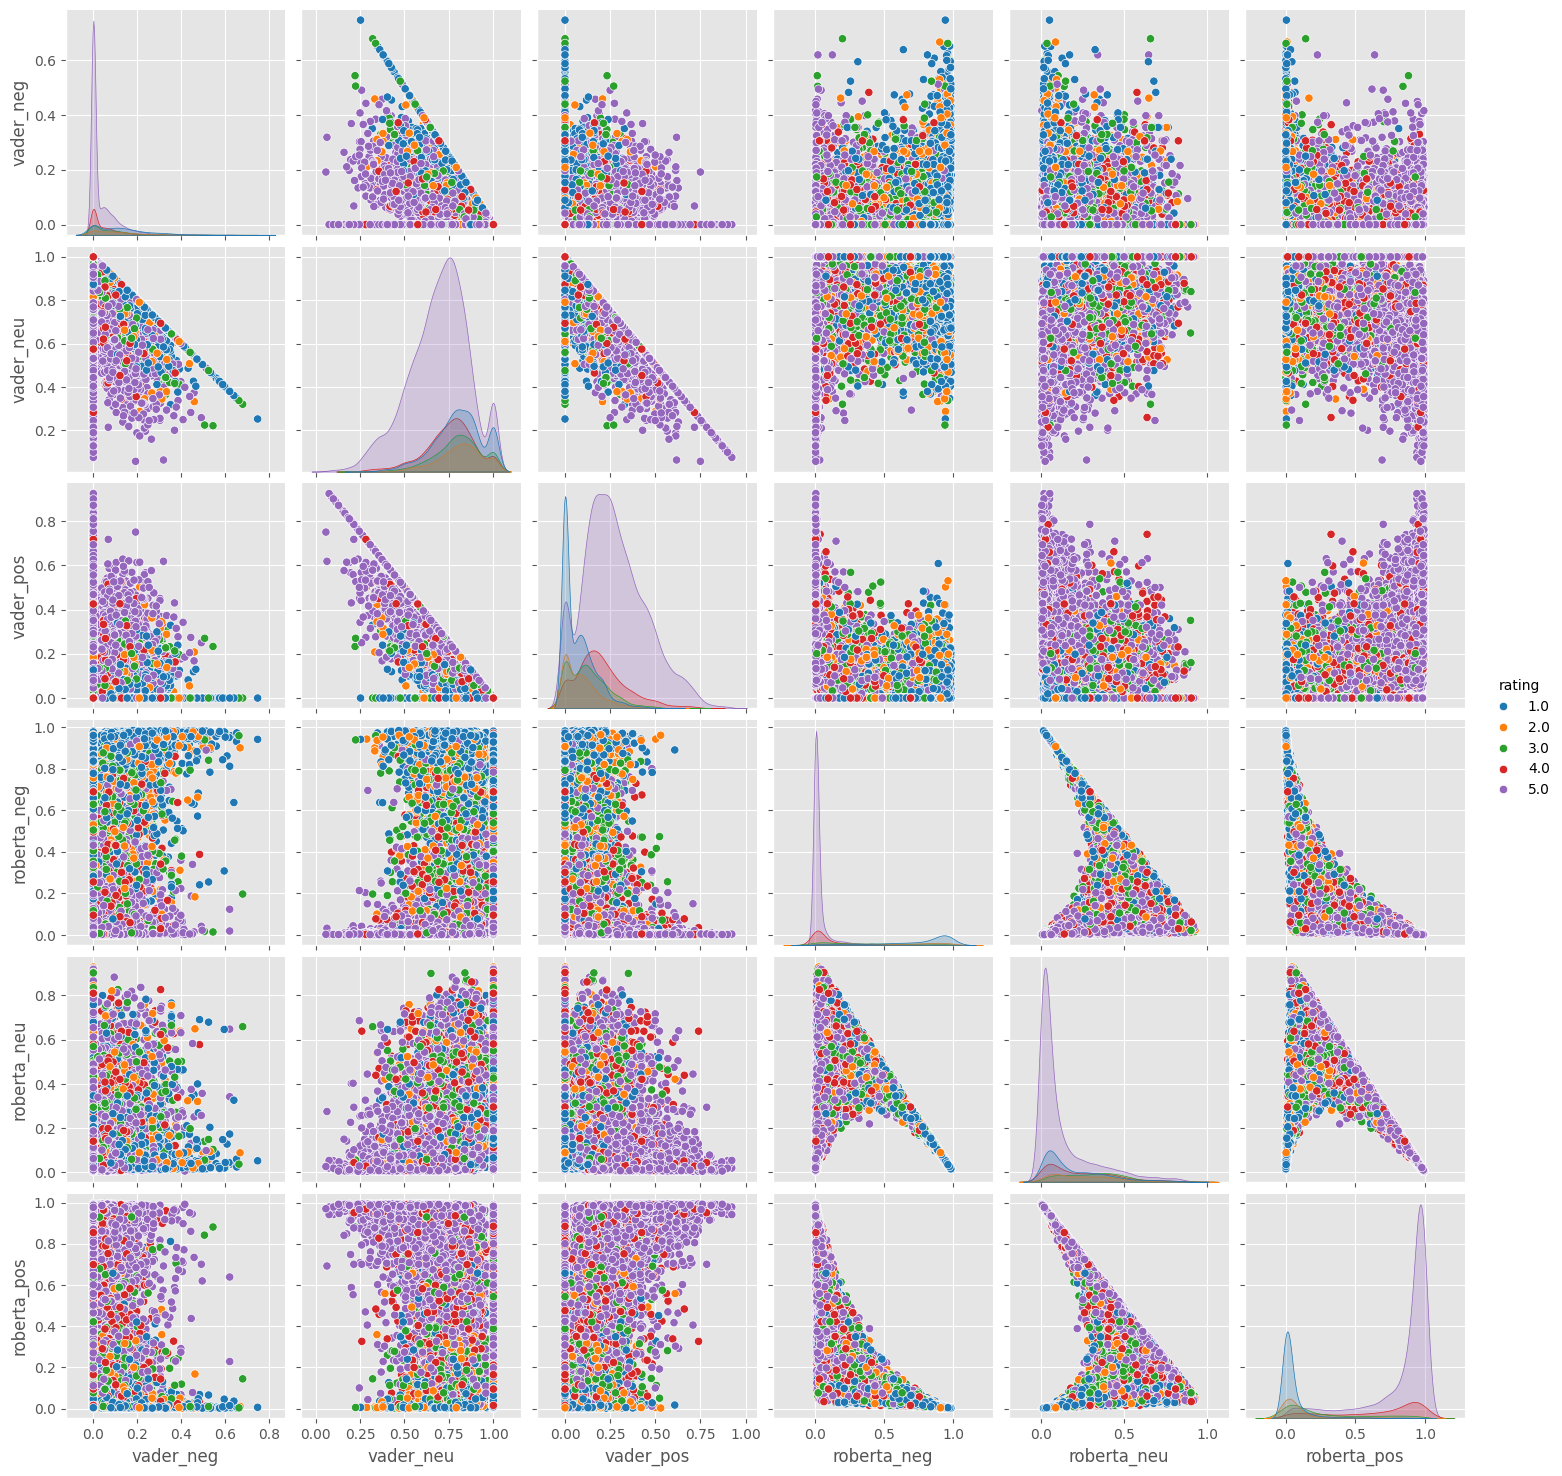

In [36]:
sns.pairplot(
    data=results_df,
    vars=[
        "vader_neg",
        "vader_neu",
        "vader_pos",
        "roberta_neg",
        "roberta_neu",
        "roberta_pos",
    ],
    hue="rating",
    palette="tab10",
)
plt.show()

In [37]:
results_df.query("rating == 1").sort_values("roberta_pos", ascending=False)[
    "text"
].values[0]

'I was excited to try out these new toothbrushes because of their sustainability and friendly aspect until I saw on the back of the packaging that the bristles are made from one of the largest chemical production companies! DOH!'

In [38]:
results_df.query("rating == 5").sort_values("roberta_neg", ascending=False)[
    "text"
].values[0]

'Love the tissues, but the boxes are all bent and three shown are the worst! The box they arrived in was flimsy and the taping of the box was poorly done which all contributed to the condition of the boxes inside. There is not one box that is decent enough looking to sit out. Very disappointed!'

## Calculating Accuracy metrics, Confusion matrix and Correlation Coefficient


In [ ]:
# Function to classify sentiment
def classify_sentiment_vader(row):
    """Classifies sentiment as positive (1) or negative (0) based on VADER scores."""
    return 1 if row["vader_pos"] > row["vader_neg"] else 0


def classify_sentiment_roberta(row):
    """Classifies sentiment as positive (1) or negative (0) based on RoBERTa scores."""
    return 1 if row["roberta_pos"] > row["roberta_neg"] else 0


# Convert star ratings to binary labels (1: Positive, 0: Negative)
results_df["true_sentiment"] = results_df["rating"].apply(
    lambda x: 1 if x >= 4 else (0 if x <= 3 else None)
)

# Remove neutral ratings (3-star) since they don't fit well into binary classification
filtered_df = results_df.dropna(subset=["true_sentiment"])

# Apply classification
filtered_df["pred_vader"] = filtered_df.apply(classify_sentiment_vader, axis=1)
filtered_df["pred_roberta"] = filtered_df.apply(classify_sentiment_roberta, axis=1)

In [78]:
# Calculate metrics for VADER
vader_accuracy = accuracy_score(
    filtered_df["true_sentiment"], filtered_df["pred_vader"]
)
vader_precision = precision_score(
    filtered_df["true_sentiment"], filtered_df["pred_vader"]
)
vader_recall = recall_score(filtered_df["true_sentiment"], filtered_df["pred_vader"])
vader_f1 = f1_score(filtered_df["true_sentiment"], filtered_df["pred_vader"])

# Calculate metrics for RoBERTa
roberta_accuracy = accuracy_score(
    filtered_df["true_sentiment"], filtered_df["pred_roberta"]
)
roberta_precision = precision_score(
    filtered_df["true_sentiment"], filtered_df["pred_roberta"]
)
roberta_recall = recall_score(
    filtered_df["true_sentiment"], filtered_df["pred_roberta"]
)
roberta_f1 = f1_score(filtered_df["true_sentiment"], filtered_df["pred_roberta"])

In [79]:
# Compute correlation coefficient between VADER and RoBERTa sentiment scores
correlation = np.corrcoef(
    filtered_df["vader_compound"],
    filtered_df["roberta_pos"] - filtered_df["roberta_neg"],
)[0, 1]

In [ ]:
print(
    f"VADER Accuracy: {vader_accuracy:.2%}, Precision: {vader_precision:.2%}, Recall: {vader_recall:.2%}, F1-score: {vader_f1:.2%}"
)
print(
    f"RoBERTa Accuracy: {roberta_accuracy:.2%}, Precision: {roberta_precision:.2%}, Recall: {roberta_recall:.2%}, F1-score: {roberta_f1:.2%}"
)

print(f"Correlation Coefficient between VADER and RoBERTa: {correlation:.4f}")

VADER Accuracy: 78.43%, Precision: 83.70%, Recall: 86.45%, F1-score: 85.05%
RoBERTa Accuracy: 89.35%, Precision: 92.28%, Recall: 92.75%, F1-score: 92.51%
Correlation Coefficient between VADER and RoBERTa: 0.6931


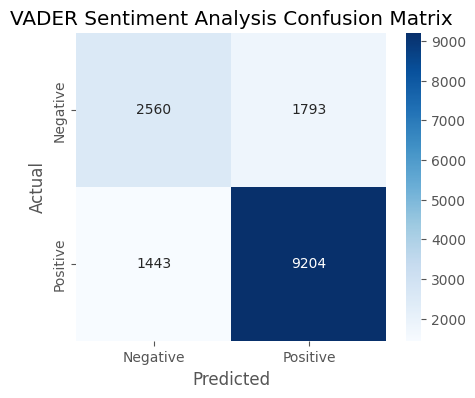

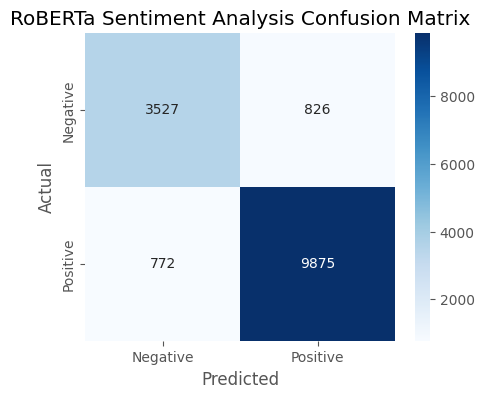

In [81]:
# Generate confusion matrices
vader_cm = confusion_matrix(filtered_df["true_sentiment"], filtered_df["pred_vader"])
roberta_cm = confusion_matrix(
    filtered_df["true_sentiment"], filtered_df["pred_roberta"]
)


# Plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


plot_confusion_matrix(vader_cm, "VADER Sentiment Analysis Confusion Matrix")
plot_confusion_matrix(roberta_cm, "RoBERTa Sentiment Analysis Confusion Matrix")

## ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [82]:
df_comp = filtered_df.copy()

## VADER - RoBERTa Hybrid model

In [92]:
def hybrid_sentiment_analysis(row):
    # Use precomputed VADER and RoBERTa scores
    vader_compound = row["vader_compound"]
    roberta_sentiment = (
        1 if row["roberta_pos"] > row["roberta_neg"] else -1
    )  # Convert to {1, -1}

    # Hybrid Decision Rule
    if vader_compound >= 0 and roberta_sentiment > 0:
        return 1
    else:
        return 0

In [93]:
df_comp["hybrid_sentiment"] = results_df.apply(hybrid_sentiment_analysis, axis=1)

In [85]:
# Load tokenizer and model for DistilBERT
MODEL_DISTILBERT = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer_distilbert = AutoTokenizer.from_pretrained(MODEL_DISTILBERT)
model_distilbert = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_DISTILBERT
)

# Load tokenizer and model for Twitter RoBERTa (replacing BERTweet)
MODEL_TWITTER_ROBERTA = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer_twitter_roberta = AutoTokenizer.from_pretrained(MODEL_TWITTER_ROBERTA)
model_twitter_roberta = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_TWITTER_ROBERTA
)

# Load tokenizer and model for XLNet
MODEL_XLNET = "xlnet-base-cased"
tokenizer_xlnet = AutoTokenizer.from_pretrained(MODEL_XLNET)
model_xlnet = TFAutoModelForSequenceClassification.from_pretrained(MODEL_XLNET)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
C:\Users\ASHUTOSH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tf_keras\src\initializers\initializers.py:121: UserWarning: The initialize

In [86]:
def analyze_sentiment(texts, tokenizer, model, batch_size=64):
    all_preds = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]  # Process small batch
        inputs = tokenizer(
            batch_texts,
            return_tensors="tf",
            truncation=True,
            padding=True,
            max_length=512,
        )
        outputs = model(**inputs)
        scores = tf.nn.softmax(outputs.logits, axis=-1).numpy()
        all_preds.extend(scores.argmax(axis=-1))  # Store predictions

    return np.array(all_preds)

In [87]:
text_list = df_comp["text"].astype(str).tolist()

In [88]:
distilbert_sentiment = analyze_sentiment(
    text_list, tokenizer_distilbert, model_distilbert
)

In [89]:
twitter_roberta_sentiment = analyze_sentiment(
    text_list, tokenizer_twitter_roberta, model_twitter_roberta
)

In [90]:
xlnet_sentiment = analyze_sentiment(text_list, tokenizer_xlnet, model_xlnet)

In [94]:
df_comp["distilbert_sentiment"] = distilbert_sentiment
df_comp["twitter_roberta_sentiment"] = twitter_roberta_sentiment
df_comp["xlnet_sentiment"] = xlnet_sentiment


df_comp["twitter_roberta_sentiment"] = df_comp["twitter_roberta_sentiment"].apply(
    lambda x: 1 if x > 0 else 0  # Merge Neutral (1) into Positive (1)
)

In [133]:
true_labels = df_comp["true_sentiment"].values.astype(int)

In [135]:
# Convert predicted labels into numeric format
vader_labels = df_comp["pred_vader"].values.astype(int)
roberta_labels = df_comp["pred_roberta"].values.astype(int)
hybrid_labels = df_comp["hybrid_sentiment"].values.astype(int)
distilbert_labels = df_comp["distilbert_sentiment"].values.astype(int)
twitter_roberta_labels = df_comp["twitter_roberta_sentiment"].values.astype(int)
xlnet_labels = df_comp["xlnet_sentiment"].values.astype(int)

In [136]:
def evaluate_model(pred_labels, model_name):
    print(f"\n=== {model_name} Evaluation ===")
    print(
        classification_report(
            true_labels, pred_labels, target_names=["Negative", "Positive"]
        )
    )
    print(f"MCC Score: {matthews_corrcoef(true_labels, pred_labels):.4f}")
    print(f"Cohen’s Kappa Score: {cohen_kappa_score(true_labels, pred_labels):.4f}")

In [141]:
evaluate_model(vader_labels, "VADER")
evaluate_model(roberta_labels, "RoBERTa")


=== VADER Evaluation ===
              precision    recall  f1-score   support

    Negative       0.64      0.59      0.61      4353
    Positive       0.84      0.86      0.85     10647

    accuracy                           0.78     15000
   macro avg       0.74      0.73      0.73     15000
weighted avg       0.78      0.78      0.78     15000

MCC Score: 0.4644
Cohen’s Kappa Score: 0.4636

=== RoBERTa Evaluation ===
              precision    recall  f1-score   support

    Negative       0.82      0.81      0.82      4353
    Positive       0.92      0.93      0.93     10647

    accuracy                           0.89     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.89      0.89      0.89     15000

MCC Score: 0.7405
Cohen’s Kappa Score: 0.7405


In [142]:
evaluate_model(hybrid_labels, "Hybrid (VADER + RoBERTa)")
evaluate_model(distilbert_labels, "DistilBERT")


=== Hybrid (VADER + RoBERTa) Evaluation ===
              precision    recall  f1-score   support

    Negative       0.74      0.83      0.78      4353
    Positive       0.93      0.88      0.90     10647

    accuracy                           0.87     15000
   macro avg       0.83      0.86      0.84     15000
weighted avg       0.87      0.87      0.87     15000

MCC Score: 0.6900
Cohen’s Kappa Score: 0.6874

=== DistilBERT Evaluation ===
              precision    recall  f1-score   support

    Negative       0.65      0.88      0.75      4353
    Positive       0.94      0.81      0.87     10647

    accuracy                           0.83     15000
   macro avg       0.80      0.84      0.81     15000
weighted avg       0.86      0.83      0.83     15000

MCC Score: 0.6400
Cohen’s Kappa Score: 0.6233


In [143]:
evaluate_model(twitter_roberta_labels, "Twitter RoBERTa")
evaluate_model(xlnet_labels, "XLNet")


=== Twitter RoBERTa Evaluation ===
              precision    recall  f1-score   support

    Negative       0.89      0.69      0.78      4353
    Positive       0.88      0.97      0.92     10647

    accuracy                           0.89     15000
   macro avg       0.89      0.83      0.85     15000
weighted avg       0.89      0.89      0.88     15000

MCC Score: 0.7160
Cohen’s Kappa Score: 0.7056

=== XLNet Evaluation ===
              precision    recall  f1-score   support

    Negative       0.41      0.09      0.15      4353
    Positive       0.72      0.95      0.82     10647

    accuracy                           0.70     15000
   macro avg       0.56      0.52      0.48     15000
weighted avg       0.63      0.70      0.62     15000

MCC Score: 0.0679
Cohen’s Kappa Score: 0.0475


In [153]:
def mcnemar_test(model1_labels, model2_labels, model1_name, model2_name):
    contingency_table = confusion_matrix(model1_labels, model2_labels)
    chi2, p, _, _ = chi2_contingency(contingency_table)

    print(f"\nStatistical Comparison: {model1_name} vs {model2_name}")
    print(f"Chi-squared value: {chi2:.4f}")
    print(f"P-value: {p:.4f}")

    if p < 0.05:
        print("Significant difference between models.\n")
    else:
        print("No significant difference between models.\n")

In [154]:
mcnemar_test(vader_labels, roberta_labels, "VADER", "RoBERTa")
mcnemar_test(roberta_labels, hybrid_labels, "RoBERTa", "Hybrid (VADER + RoBERTa)")
mcnemar_test(hybrid_labels, distilbert_labels, "Hybrid", "DistilBERT")
mcnemar_test(distilbert_labels, twitter_roberta_labels, "DistilBERT", "Twitter RoBERTa")
mcnemar_test(twitter_roberta_labels, xlnet_labels, "Twitter RoBERTa", "XLNet")


Statistical Comparison: VADER vs RoBERTa
Chi-squared value: 4522.0568
P-value: 0.0000
Significant difference between models.


Statistical Comparison: RoBERTa vs Hybrid (VADER + RoBERTa)
Chi-squared value: 12397.9971
P-value: 0.0000
Significant difference between models.


Statistical Comparison: Hybrid vs DistilBERT
Chi-squared value: 6996.6133
P-value: 0.0000
Significant difference between models.


Statistical Comparison: DistilBERT vs Twitter RoBERTa
Chi-squared value: 5736.7857
P-value: 0.0000
Significant difference between models.


Statistical Comparison: Twitter RoBERTa vs XLNet
Chi-squared value: 70.6041
P-value: 0.0000
Significant difference between models.

